# SWMAL Exercise

## Pipelines
$$
    \newcommand\rem[1]{}
    \rem{SWMAL: CEF def and LaTeX commands, remember: no newlines in defs}
    \newcommand\eq[2]{#1 &=& #2\\}
    \newcommand\ar[2]{\begin{array}{#1}#2\end{array}}
    \newcommand\ac[2]{\left[\ar{#1}{#2}\right]}
    \newcommand\st[1]{_{\scriptsize #1}}
    \newcommand\norm[1]{{\cal L}_{#1}}
    \newcommand\obs[2]{#1_{\text{\scriptsize obs}}^{\left(#2\right)}}
    \newcommand\diff[1]{\text{d}#1}
    \newcommand\pown[1]{^{(#1)}}
    \def\pownn{\pown{n}}
    \def\powni{\pown{i}}
    \def\powtest{\pown{\text{\scriptsize test}}}
    \def\powtrain{\pown{\text{\scriptsize train}}}
    \def\bX{\mathbf{M}}
    \def\bX{\mathbf{X}}
    \def\bZ{\mathbf{Z}}
    \def\bw{\mathbf{m}}
    \def\bx{\mathbf{x}}
    \def\by{\mathbf{y}}
    \def\bz{\mathbf{z}}
    \def\bw{\mathbf{w}}
    \def\btheta{{\boldsymbol\theta}}
    \def\bSigma{{\boldsymbol\Sigma}}
    \def\half{\frac{1}{2}}
$$
We are going to implement a min/max scaler for a multilayer perceptron (MLP). The MLP is designed to receive input data within specific ranges: `[0;1]` or `[-1;1]`. The min/max scaler will adjust the data accordingly, ensuring that it falls within the expected range and preventing saturation to the minimum or maximum values.

In [2]:
%matplotlib inline

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def LoadDataFromL01():
    filename = "Data/itmal_l01_data.pkl"
    with open(f"{filename}", "rb") as f:
        (X, y) = pickle.load(f)
        return X, y

X, y = LoadDataFromL01()

print(f"X.shape={X.shape},  y.shape={y.shape}")

assert X.shape[0] == y.shape[0]
assert X.ndim == 2
assert y.ndim == 1  # did a y.ravel() before saving to picke file
assert X.shape[0] == 29

# re-create plot data (not stored in the Pickel file)
m = np.linspace(0, 60000, 1000)
M = np.empty([m.shape[0], 1])
M[:, 0] = m

print("OK")

X.shape=(29, 1),  y.shape=(29,)
OK


The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=-12295.72

OK


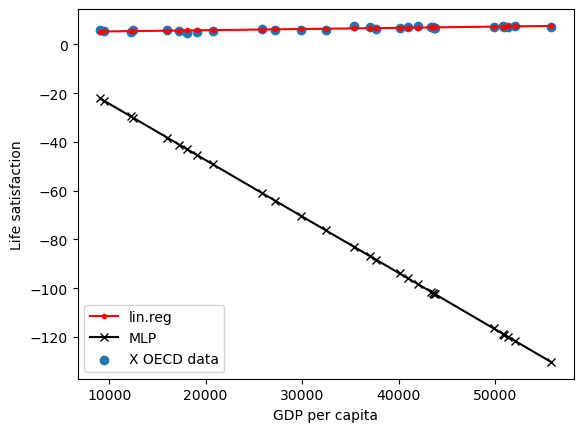

In [4]:
# Setup the MLP and lin. regression again..

def isNumpyData(t: np.ndarray, expected_ndim: int):
    assert isinstance(expected_ndim, int), f"input parameter 'expected_ndim' is not an integer but a '{type(expected_ndim)}'"
    assert expected_ndim>=0, f"expected input parameter 'expected_ndim' to be >=0, got {expected_ndim}"
    if t is None:
        print("input parameter 't' is None", file=sys.stderr)
        return False
    if not isinstance(t, np.ndarray):
        print("excepted numpy.ndarray got type '{type(t)}'", file=sys.stderr)
        return False
    if not t.ndim==expected_ndim:
        print("expected ndim={expected_ndim} but found {t.ndim}", file=sys.stderr)
        return False
    return True

def PlotModels(model1, model2, X: np.ndarray, y: np.ndarray, name_model1: str, name_model2: str):
    
    # NOTE: local function is such a nifty feature of Python!
    def CalcPredAndScore(model, X: np.ndarray, y: np.ndarray,):
        assert isNumpyData(X, 2) and isNumpyData(y, 1) and X.shape[0]==y.shape[0]
        y_pred_model = model.predict(X)
        score_model = r2_score(y, y_pred_model) # call r2
        return y_pred_model, score_model    

    assert isinstance(name_model1, str) and isinstance(name_model2, str)

    y_pred_model1, score_model1 = CalcPredAndScore(model1, X, y)
    y_pred_model2, score_model2 = CalcPredAndScore(model2, X, y)

    plt.plot(X, y_pred_model1, "r.-")
    plt.plot(X, y_pred_model2, "kx-")
    plt.scatter(X, y)
    plt.xlabel("GDP per capita")
    plt.ylabel("Life satisfaction")
    plt.legend([name_model1, name_model2, "X OECD data"])

    l = max(len(name_model1), len(name_model2))
    
    print(f"{(name_model1).rjust(l)}.score(X, y)={score_model1:0.2f}")
    print(f"{(name_model2).rjust(l)}.score(X, y)={score_model2:0.2f}")

# lets make a linear and MLP regressor and redo the plots
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
linreg = LinearRegression()

mlp.fit(X, y)
linreg.fit(X, y)

print("The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..\n")
PlotModels(linreg, mlp, X, y, "lin.reg", "MLP")
print("\nOK")

### Qa) Create a Min/max scaler for the MLP

This first version we are creating is the default version si most simplified solution. Here we take the max and min value from X. From that we are calculating the standardization.

$$
    \ar{rl}{
        \text{x'} &= \frac{\text{x}-\mu_x}{\sigma_x} 
    }
$$

Now we can re-train the MLP and re-plot with the preprocess data.

maxvalue=55805.204000000005
minvalue=9054.914
The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=0.73

OK


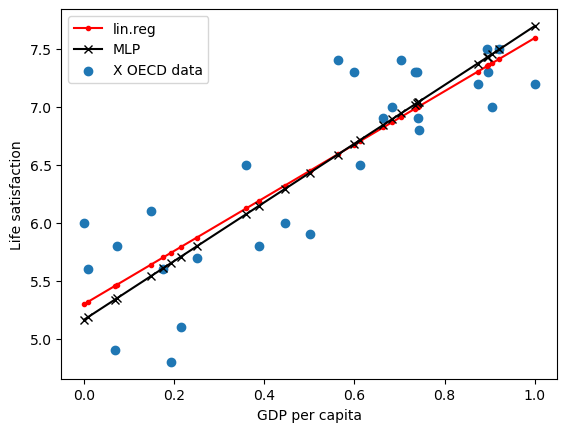

In [5]:
maxvalue= X.max()
print(f"maxvalue={maxvalue}")
minvalue= X.min()
print(f"minvalue={minvalue}")

X_scaled = (X-minvalue)/(maxvalue-minvalue)

mlp.fit(X_scaled, y)
linreg.fit(X_scaled, y)
print("The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..\n")
PlotModels(linreg, mlp, X_scaled, y, "lin.reg", "MLP")
print("\nOK")

### Qb) Scikit-learn Pipelines

Now, we will perform the re-scaling again, this time using a pipeline and a scaler from sklearn. We will be utilizing sklearn.pipeline.Pipeline and sklearn.preprocessing.MinMaxScaler. The pipeline acts as an intelligent composite constructor, which reduces the number of variables involved. This is achieved by directly passing the scaled values into the model we intend to train. This is done by calling the `pipe.fit()`.

Again we are using the `PlotModels()` function to retraing the linear regressor on the scaled data.

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=0.72


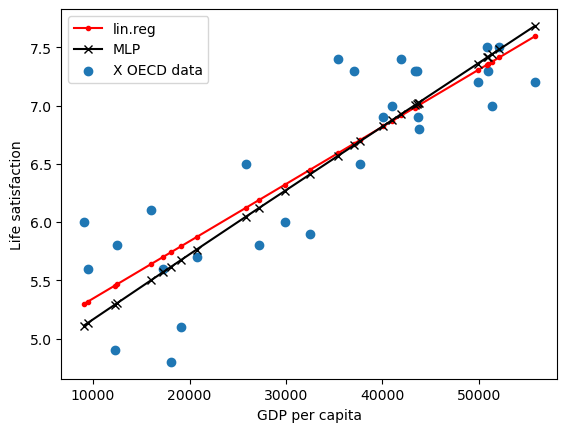

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline(
    [
        ('Scaler', MinMaxScaler()), 
        ('mlp',mlp)
    ]
)
pipe.fit(X, y)
linreg.fit(X, y)
PlotModels(linreg, pipe, X, y, "lin.reg", "MLP")

### Qc) Outliers and the Min-max Scaler vs. the Standard Scaler

The fundamental problem with the min/max scaler is it linearly transforms the data to fit within a specified range `[0;1]` or `[-1;1]`. This means the min and max value often can be set by outliers and can cause the data to be distortion of the overall distribution. It can be a single outliers with an extremly low value, the min/max scaler will strech to fit the one outlier. So the rest of the data is getting a more narrow range, this can lead to potentially losing important information.

On the other hand we have the standard scaler, which is less sensitive to ouliers. This is because the standard scale preforms z-score normalization, which is part of statics. In other words this processs center the data around 0 and scales it based on its variance. So the bigger standard variance the less influence on the scaling.

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=0.80


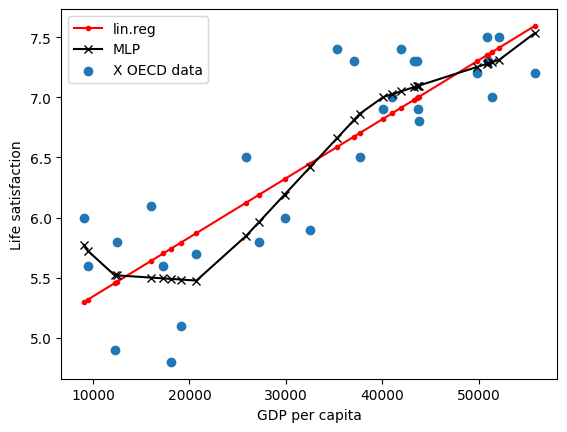

In [6]:
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('Scaler', StandardScaler()), ('mlp',mlp)])

pipe.fit(X, y)
linreg.fit(X, y)
PlotModels(linreg, pipe, X, y, "lin.reg", "MLP")

### Qd) Modify the MLP Hyperparameters

Now we want to try chaning the different hyperparametes associated with the MLP. We are going to try chaning the amount of neurons, solver and the activation. We will use the $R^2$. to check if the output still is sensible. 

Firstly try new amount of neurons, we are chaning from 10 to 5. 

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=0.73


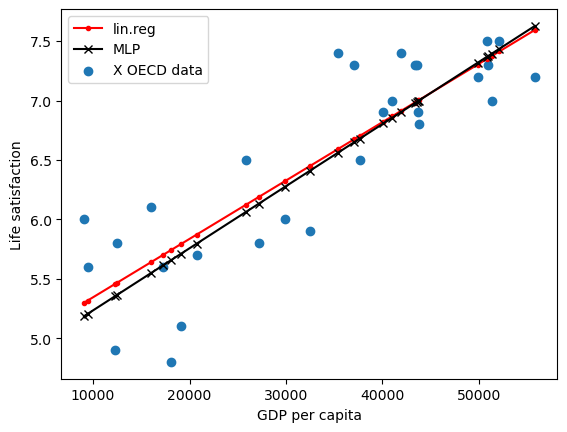

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(hidden_layer_sizes=(5, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)


pipe = Pipeline(
    [
        ('Scaler', MinMaxScaler()), 
        ('mlp',mlp)
    ]
)
pipe.fit(X, y)
linreg.fit(X, y)
PlotModels(linreg, pipe, X, y, "lin.reg", "MLP")

We can observe that the MLP still prefromce fine with 5 neurons. So we are now testing for only one neurons. 

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=0.70


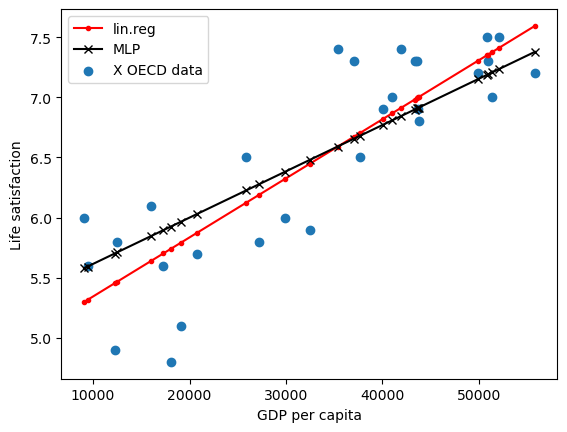

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(hidden_layer_sizes=(1, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)


pipe = Pipeline(
    [
        ('Scaler', MinMaxScaler()), 
        ('mlp',mlp)
    ]
)
pipe.fit(X, y)
linreg.fit(X, y)
PlotModels(linreg, pipe, X, y, "lin.reg", "MLP")

The $R^2$ is only a little amount worse than the linear regression. 

Now we are going to try using a new activation functions. This is a mathematical operations applied to the output of a neuron in a neural network. This helps introducing a non-linearity into the network. This allows the neural network to learn and model complex relationships btween input and output. We are using the logistic also called simoid function. The Formula is 
$$
    \ar{rl}{
        f(x) &= \frac{1}{1+(e)^{-x}} 
    }
$$

The formula output range is between `[0;1]`

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=0.72


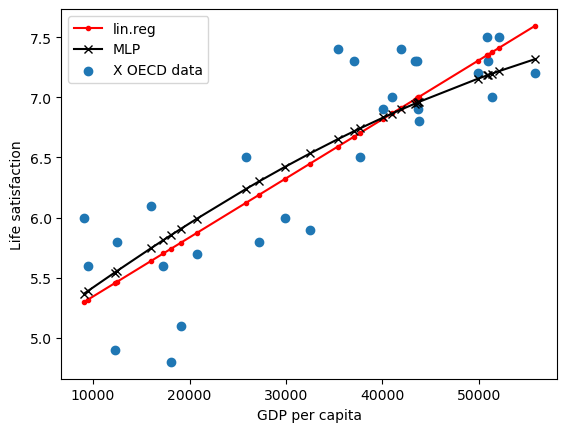

In [13]:
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='logistic',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
pipe = Pipeline(
    [
        ('Scaler', MinMaxScaler()), 
        ('mlp',mlp)
    ]
)
pipe.fit(X, y)
linreg.fit(X, y)
PlotModels(linreg, pipe, X, y, "lin.reg", "MLP")

Chaning the activation function to be logistic the $R^2$ is only a little amount worse than the linear regression. You can obsever the shape is non-linear. 

Now we want to try to use a different solver. We are going with the stochastic gradient descent`sgd` instead of the `adam`. This is a algorithm that is often use in matchine learning. It is a variant of the standard gradient descent algorithm.  

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=0.50


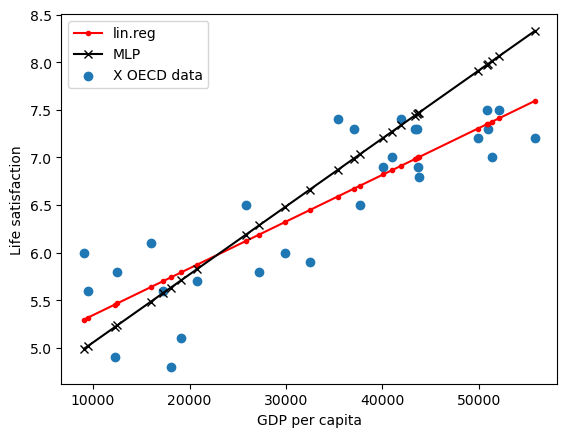

In [9]:
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='sgd',  # Try different solvers
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
pipe = Pipeline(
    [
        ('Scaler', MinMaxScaler()), 
        ('mlp',mlp)
    ]
)
pipe.fit(X, y)
linreg.fit(X, y)
PlotModels(linreg, pipe, X, y, "lin.reg", "MLP")